In [41]:
import os
import torch
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import scipy
from torchvision import transforms, utils

In [42]:
np.random.seed(19680801)

In [46]:
! pip install deeptrack

  Using cached deeptrack-1.5.6-py3-none-any.whl (190 kB)
  Using cached tensorflow-2.13.0-cp39-cp39-macosx_10_15_x86_64.whl (216.2 MB)
  Using cached numpydoc-1.5.0-py3-none-any.whl (52 kB)
  Using cached tensorflow_probability-0.20.1-py2.py3-none-any.whl (6.9 MB)
  Using cached tensorflow_datasets-4.9.2-py3-none-any.whl (5.4 MB)
  Using cached Pint-0.19.2.tar.gz (292 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 15.9 MB/s eta 0:00:00m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.6 MB/s eta 0:00:00m eta 0:00:010:01
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 39.0 MB/

In [3]:
! pip install --force-reinstall charset-normalizer==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 2.3 MB/s eta 0:00:000:00:01
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.0.4
    Uninstalling charset-normalizer-2.0.4:
      Successfully uninstalled charset-normalizer-2.0.4


In [131]:
#how to read from the file path??

def rototranslate(translate, rotate, input):
        # if isinstance(image, np.array):
        #     input = image.numpy()

        cr = np.cos(rotate)
        sr = np.sin(rotate)

        mapping = np.array([[cr, sr], [-sr, cr]])

        dx, dy = translate
        
        shape = input.shape
        center = np.array(shape[:2]) / 2

        d = center - np.dot(mapping, center) - np.array([dy, dx])
        # print(mapping)

        new_image = scipy.ndimage.affine_transform(
                input=input,
                matrix=mapping,
                offset=d
            )
        return new_image

#For now, hardfix the batch_si
#this should create rototranslations within the constructor and getitem should just index
class RotationData(Dataset):
    def __init__(self, img_path, set_size, transform) -> None:
        # super().__init__()
        self.img_path = img_path #img path within the current working directory
        self.transform = transform
        self.set_size = set_size

        img_name = os.path.join(os.getcwd(), self.img_path)
        img = io.imread(img_name)
        # print(type(img))
        # img = np.load(img_name, allow_pickle=True)
        # if len(img.shape) > 1:
        #     img = skimage.color.rgb2gray(img)


    #dataset is a list of 
    ## Guess: dataloader accesses getitem in order to get batches
    # a batch [samples x batchsize]
        self.param_list = [(np.random.randint(-2, 2), np.random.randint(-2, 2),  np.pi * np.random.rand()) for i in range(set_size)]
        self.image_list = [rototranslate((dx, dy), theta, img) for dx, dy, theta in self.param_list]

    def __len__(self):
         return int(self.set_size)
    def __getitem__(self, index):
        
        #output a list of [dx, dy, theta] tuples,
        sample = {'xytheta' : self.param_list[index], 'image': self.image_list[index]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    

In [132]:
class GaussianNoise(object):
    def __init__(
        self, mu = 0, sigma = 1, **kwargs
    ):
        self.mu = mu
        self.sigma = sigma
    def __call__(self, sample):
        # assert isinstance(sample['image'], np.ndarray)
        noisy_image = self.mu + sample['image'] + np.random.randn(*sample['image'].shape) * self.sigma
        return {'xytheta': sample['xytheta'], 'image' : noisy_image}
    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = image.transpose((2, 0, 1))
        #OUR IMAGES ARE GRAYSCALE!!!
        return {'xytheta': torch.tensor(list(sample['xytheta'])), 'image': torch.from_numpy(image)}

In [135]:
##How are batches actually creates in the dataloader??
rotated_cell_data = RotationData('img/t1763.tif', 20, transform = transforms.Compose([GaussianNoise(), ToTensor()]))
dataloader = DataLoader(rotated_cell_data, batch_size=4,
                        shuffle=True, num_workers=0)
# for i_batch, sample_batched in enumerate(dataloader):
#     print(sample_batched['image'].size())
sample = next(iter(dataloader))

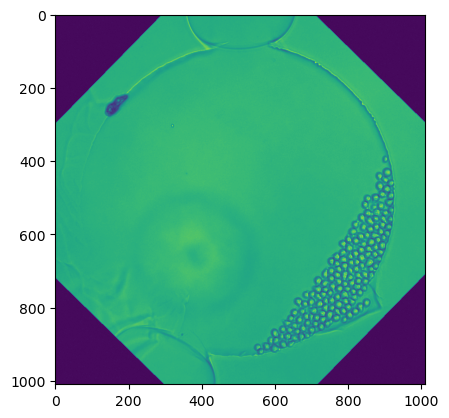

In [139]:
plt.imshow(sample["image"][3])
plt.show()

0 torch.Size([4, 3]) torch.Size([4, 1010, 1010])
1 torch.Size([4, 3]) torch.Size([4, 1010, 1010])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([4, 3]) torch.Size([4, 1010, 1010])
3 torch.Size([4, 3]) torch.Size([4, 1010, 1010])


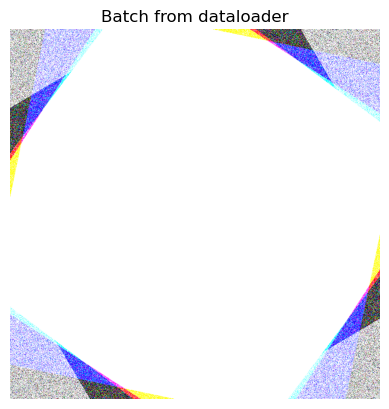

In [134]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(1)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        # plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
        #             landmarks_batch[i, :, 1].numpy() + grid_border_size,
        #             s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['xytheta'].size(),
          sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [129]:
sample['xytheta'][0]

tensor([0.0000, 1.0000, 1.9325])

In [130]:
sample['image'][0]

tensor([[-1.4435,  1.9731,  0.3305,  ..., -0.0173, -0.9157,  1.4756],
        [ 0.6543, -1.4119,  0.5597,  ..., -0.5847, -0.3093, -2.5730],
        [ 0.2625,  1.2598,  1.9393,  ..., -0.9514,  1.6548, -0.6716],
        ...,
        [ 1.1461,  0.2316, -0.2701,  ...,  1.7855,  0.4403, -0.4194],
        [ 0.3011,  0.0051, -0.4645,  ..., -0.0991, -1.0886,  0.1463],
        [ 0.5655, -2.6412, -0.1762,  ..., -0.4439,  1.2169, -1.8846]],
       dtype=torch.float64)

In [62]:
rotated_cell_data = RotationData('img/t1763.tif', 8, transform = transforms.Compose([]))


<class 'numpy.ndarray'>


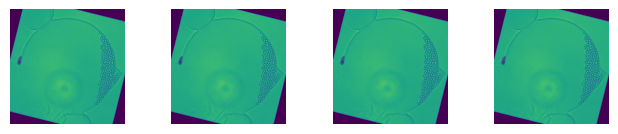

In [60]:
def show_images(ax, **kwargs):
    for i, img in enumerate(kwargs['image']):
        plt.imshow(img)
    

#returns a single batch
for i, sample in enumerate(rotated_cell_data):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    # ax.set_title(sample['rotation_translation'])
    ax.axis('off')
    show_images(ax, **sample)
    # plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [ ]:



# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i, sample in enumerate(rotated_cell_data):
    # print(i, sample['rotation_translation'], sample['image'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    # show_landmarks(**sample)
    plt.imshow()

    if i == 3:
        plt.show()
        break